## CartPole

In [1]:
import gym
import numpy as np
import torch
import torch.nn as nn
import random
from tqdm import tqdm
import matplotlib.pyplot as plt
import os
os.environ["KMP_DUPLICATE_LIB_OK"] = "TRUE"

In [2]:
env = gym.make('CartPole-v0')

In [3]:
## set seed
seed = 123
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
random.seed(seed)
env.seed(seed)
env.action_space.np_random.seed(seed)

### Method 1. DQN

In [4]:
## Experience Set(for experience replay)

class Experience():
    def __init__(self, capacity = 20000):
        self.experience = []  ## store （s,a,r,s'）
        self.capacity = capacity  ## max capacity
        self.volume = 0  ## current capacity
        self.iter = 0
        
    def insert(self, transition):
        if self.volume < self.capacity:
            ## insert directly
            self.experience.append(transition)
            self.volume += 1
        else:
            ## random choose a transition to cover
            self.experience[self.iter] = transition
            self.iter = (self.iter + 1) % self.capacity
    
    def sample(self, batch_size):
        ## random sample a batch including batch_size transitions
        return random.sample(self.experience, k = batch_size)

In [5]:
experience = Experience()

for e in range(100):
    s0 = env.reset()
    is_end = False
    while not is_end:
        action = env.action_space.sample()
        s1, reward, is_end, _ = env.step(action)
        experience.insert([s0,action,reward,s1])
        s0 = s1

In [6]:
class QNetwork(nn.Module):
    def __init__(self,obs_space,hidden_dim,output_dim,action_space):
        super(QNetwork,self).__init__()
        self.Network = nn.Sequential(
            nn.Linear(obs_space,hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim,hidden_dim // 2),
            nn.ReLU(),
            nn.Linear(hidden_dim // 2,hidden_dim // 4),
            nn.ReLU(),
            nn.Linear(hidden_dim // 4, output_dim),
            nn.ReLU(),
            nn.Linear(output_dim, action_space)
        )
        
    def forward(self,x):
        return self.Network(x)

In [7]:
## Agent

class DQNAgent():
    def __init__(self, env, experience, hidden_dim, output_dim, gamma = 0.9, epsilon = 0.1, decay_rate = 1, learning_rate = 1e-4):
        self.env = env
        self.action_space = env.action_space  
        self.obs_space = env.observation_space.shape[0]
        self.action_len = len([i for i in range(self.action_space.n)])
        self.experience = experience
        
        self.device = 'cuda' if torch.cuda.is_available() else 'cpu'
        self.behaviour_QNetwork = QNetwork(self.obs_space, hidden_dim, output_dim, self.action_len).to(self.device)
        self.target_QNetwork = QNetwork(self.obs_space, hidden_dim, output_dim, self.action_len).to(self.device)
        self.loss_fn = nn.MSELoss()
        self.optimizer = torch.optim.Adam(self.behaviour_QNetwork.parameters(), lr = learning_rate)
        
        self.epsilon = epsilon
        self.decay_rate = decay_rate
        self.gamma = gamma
        
    def policy(self, state, epsilon = 0.1):
        if np.random.random() < epsilon:
            action = self.action_space.sample()
        else:
            score = self.behaviour_QNetwork(torch.Tensor(state).to(self.device)).detach()
            action = torch.argmax(score).item()
            
        return action
    
    def learn(self, batch_size, display = False):
        s0 = self.env.reset()
        if display:
            self.env.render()
        is_end = False
        episode_reward = 0
        
        while not is_end:
            ## choose an action and make a step
            a0 = self.policy(s0, epsilon = self.epsilon)
            s1, reward, is_end, _ = self.env.step(a0)
            if display:
                self.env.render()
            if is_end:
                s1 = np.array([100,100,100,100])
            ## store the transition into experience
            self.experience.insert([s0,a0,reward,s1])
            ## sample minibatch from experience
            minibatch = self.experience.sample(batch_size = batch_size)
            s, a, r, s_next = [], [], [], []
            for batch in minibatch:
                s.append(batch[0])
                a.append(batch[1])
                r.append(batch[2])
                s_next.append(batch[3])
            s = torch.Tensor(s).to(self.device)
            a = torch.LongTensor(a).to(self.device).reshape(-1,1)
            r = torch.Tensor(r).to(self.device).reshape(-1,1)
            s_next = torch.Tensor(s_next).to(self.device)
            Q_target = r + self.gamma * torch.max(self.target_QNetwork(s_next),1)[0].reshape(-1,1) * (s_next[:,0] != 100).reshape(-1,1)
            Q_behaviour = self.behaviour_QNetwork(s).gather(1,a)
            loss = self.loss_fn(Q_target, Q_behaviour)
            self.optimizer.zero_grad()
            loss.backward()
            self.optimizer.step()
            ## iteration
            s0 = s1
            episode_reward += reward
        
        ## update target network
        self.target_QNetwork.load_state_dict(self.behaviour_QNetwork.state_dict())
        self.epsilon *= self.decay_rate
        
        return episode_reward, loss.item()
    
    def save_model(self):
        torch.save(self.behaviour_QNetwork, 'saved_model\DQN')
        
    def load_model(self):
        self.behaviour_QNetwork = torch.load('saved_model\DQN')
        self.target_QNetwork.load_state_dict(self.behaviour_QNetwork.state_dict())


In [8]:
## train
dqn_agent = DQNAgent(env, experience, hidden_dim = 16,output_dim = 3, gamma = 0.99, epsilon = 0.1, decay_rate = 0.99, learning_rate = 1e-3)
MAX_EPISODE = 2000
dqn_episode_reward = []
dqn_loss = []
average_100_step = []

save_flag = False
max_reward = 0

for e in tqdm(range(MAX_EPISODE)):
    reward, loss = dqn_agent.learn(batch_size = 100, display = False)
    dqn_episode_reward.append(reward)
    avg_mean = np.mean(dqn_episode_reward[-100:])
    average_100_step.append(avg_mean)
    dqn_loss.append(loss)    
    
    ## save model
    if avg_mean > 180:
        if save_flag == False:
            dqn_agent.save_model()
            save_flag = True
            max_reward = avg_mean
            print("model saved, episode:",e,"average mean of last 100 episodes:",avg_mean)
        else:
            if avg_mean >= max_reward:
                dqn_agent.save_model()
                max_reward = avg_mean
                print("model saved, episode:",e,"average mean of last 100 episodes:",avg_mean)


 36%|████████████████████████████▋                                                  | 725/2000 [04:12<18:47,  1.13it/s]

model saved, episode: 724 average mean of last 100 episodes: 180.59


 36%|████████████████████████████▋                                                  | 726/2000 [04:12<18:55,  1.12it/s]

model saved, episode: 725 average mean of last 100 episodes: 181.16


 36%|████████████████████████████▋                                                  | 727/2000 [04:13<19:00,  1.12it/s]

model saved, episode: 726 average mean of last 100 episodes: 181.91


 36%|████████████████████████████▊                                                  | 728/2000 [04:14<19:09,  1.11it/s]

model saved, episode: 727 average mean of last 100 episodes: 182.69


 36%|████████████████████████████▊                                                  | 729/2000 [04:15<19:11,  1.10it/s]

model saved, episode: 728 average mean of last 100 episodes: 183.42


 36%|████████████████████████████▊                                                  | 730/2000 [04:16<19:11,  1.10it/s]

model saved, episode: 729 average mean of last 100 episodes: 183.78


 37%|████████████████████████████▊                                                  | 731/2000 [04:17<19:10,  1.10it/s]

model saved, episode: 730 average mean of last 100 episodes: 183.78


 38%|█████████████████████████████▋                                                 | 750/2000 [04:34<19:01,  1.10it/s]

model saved, episode: 749 average mean of last 100 episodes: 183.87


 38%|█████████████████████████████▋                                                 | 751/2000 [04:35<18:59,  1.10it/s]

model saved, episode: 750 average mean of last 100 episodes: 183.96


 38%|█████████████████████████████▋                                                 | 752/2000 [04:36<19:00,  1.09it/s]

model saved, episode: 751 average mean of last 100 episodes: 183.99


 38%|█████████████████████████████▋                                                 | 753/2000 [04:37<19:39,  1.06it/s]

model saved, episode: 752 average mean of last 100 episodes: 184.18


 38%|█████████████████████████████▊                                                 | 754/2000 [04:38<19:59,  1.04it/s]

model saved, episode: 753 average mean of last 100 episodes: 184.67


 38%|█████████████████████████████▊                                                 | 755/2000 [04:39<19:39,  1.06it/s]

model saved, episode: 754 average mean of last 100 episodes: 185.09


 38%|█████████████████████████████▊                                                 | 756/2000 [04:40<19:29,  1.06it/s]

model saved, episode: 755 average mean of last 100 episodes: 185.48


 38%|█████████████████████████████▉                                                 | 757/2000 [04:41<19:17,  1.07it/s]

model saved, episode: 756 average mean of last 100 episodes: 186.0


 38%|█████████████████████████████▉                                                 | 758/2000 [04:42<19:09,  1.08it/s]

model saved, episode: 757 average mean of last 100 episodes: 186.48


 38%|█████████████████████████████▉                                                 | 759/2000 [04:43<19:02,  1.09it/s]

model saved, episode: 758 average mean of last 100 episodes: 186.88


 38%|██████████████████████████████                                                 | 760/2000 [04:43<18:57,  1.09it/s]

model saved, episode: 759 average mean of last 100 episodes: 187.14


 38%|██████████████████████████████                                                 | 761/2000 [04:44<18:58,  1.09it/s]

model saved, episode: 760 average mean of last 100 episodes: 187.14


 38%|██████████████████████████████                                                 | 762/2000 [04:45<18:55,  1.09it/s]

model saved, episode: 761 average mean of last 100 episodes: 187.14


 38%|██████████████████████████████▏                                                | 763/2000 [04:46<18:57,  1.09it/s]

model saved, episode: 762 average mean of last 100 episodes: 187.14


 38%|██████████████████████████████▏                                                | 764/2000 [04:47<18:56,  1.09it/s]

model saved, episode: 763 average mean of last 100 episodes: 187.58


 38%|██████████████████████████████▏                                                | 765/2000 [04:48<18:52,  1.09it/s]

model saved, episode: 764 average mean of last 100 episodes: 188.06


 38%|██████████████████████████████▎                                                | 766/2000 [04:49<18:49,  1.09it/s]

model saved, episode: 765 average mean of last 100 episodes: 188.48


 38%|██████████████████████████████▎                                                | 767/2000 [04:50<18:53,  1.09it/s]

model saved, episode: 766 average mean of last 100 episodes: 188.81


 38%|██████████████████████████████▎                                                | 768/2000 [04:51<19:04,  1.08it/s]

model saved, episode: 767 average mean of last 100 episodes: 189.25


 38%|██████████████████████████████▍                                                | 769/2000 [04:52<19:24,  1.06it/s]

model saved, episode: 768 average mean of last 100 episodes: 189.51


 38%|██████████████████████████████▍                                                | 770/2000 [04:53<19:44,  1.04it/s]

model saved, episode: 769 average mean of last 100 episodes: 189.51


 39%|██████████████████████████████▍                                                | 771/2000 [04:54<19:58,  1.03it/s]

model saved, episode: 770 average mean of last 100 episodes: 189.71


 39%|██████████████████████████████▍                                                | 772/2000 [04:55<20:06,  1.02it/s]

model saved, episode: 771 average mean of last 100 episodes: 190.0


 39%|██████████████████████████████▌                                                | 773/2000 [04:56<20:12,  1.01it/s]

model saved, episode: 772 average mean of last 100 episodes: 190.39


 39%|██████████████████████████████▌                                                | 774/2000 [04:57<20:17,  1.01it/s]

model saved, episode: 773 average mean of last 100 episodes: 190.92


 39%|██████████████████████████████▌                                                | 775/2000 [04:58<20:27,  1.00s/it]

model saved, episode: 774 average mean of last 100 episodes: 191.28


 39%|██████████████████████████████▋                                                | 777/2000 [05:00<19:16,  1.06it/s]

model saved, episode: 776 average mean of last 100 episodes: 191.37


 39%|██████████████████████████████▋                                                | 778/2000 [05:01<19:32,  1.04it/s]

model saved, episode: 777 average mean of last 100 episodes: 191.73


 39%|██████████████████████████████▊                                                | 779/2000 [05:02<19:49,  1.03it/s]

model saved, episode: 778 average mean of last 100 episodes: 192.45


 39%|██████████████████████████████▊                                                | 781/2000 [05:03<17:42,  1.15it/s]

model saved, episode: 780 average mean of last 100 episodes: 192.99


 39%|██████████████████████████████▉                                                | 782/2000 [05:04<17:54,  1.13it/s]

model saved, episode: 781 average mean of last 100 episodes: 193.8


 39%|██████████████████████████████▉                                                | 783/2000 [05:05<18:04,  1.12it/s]

model saved, episode: 782 average mean of last 100 episodes: 194.5


 39%|██████████████████████████████▉                                                | 784/2000 [05:06<18:08,  1.12it/s]

model saved, episode: 783 average mean of last 100 episodes: 195.1


 39%|███████████████████████████████                                                | 785/2000 [05:07<18:11,  1.11it/s]

model saved, episode: 784 average mean of last 100 episodes: 195.38


 39%|███████████████████████████████                                                | 786/2000 [05:08<18:12,  1.11it/s]

model saved, episode: 785 average mean of last 100 episodes: 195.76


 39%|███████████████████████████████                                                | 787/2000 [05:08<18:13,  1.11it/s]

model saved, episode: 786 average mean of last 100 episodes: 195.76


 39%|███████████████████████████████▏                                               | 788/2000 [05:09<18:16,  1.11it/s]

model saved, episode: 787 average mean of last 100 episodes: 195.76


 39%|███████████████████████████████▏                                               | 789/2000 [05:10<18:15,  1.11it/s]

model saved, episode: 788 average mean of last 100 episodes: 195.76


 45%|███████████████████████████████████▎                                           | 895/2000 [06:43<16:36,  1.11it/s]

model saved, episode: 894 average mean of last 100 episodes: 196.65


 45%|███████████████████████████████████▍                                           | 896/2000 [06:43<16:36,  1.11it/s]

model saved, episode: 895 average mean of last 100 episodes: 198.01


 45%|███████████████████████████████████▍                                           | 897/2000 [06:44<16:39,  1.10it/s]

model saved, episode: 896 average mean of last 100 episodes: 199.59


 45%|███████████████████████████████████▍                                           | 898/2000 [06:45<16:40,  1.10it/s]

model saved, episode: 897 average mean of last 100 episodes: 199.59


 45%|███████████████████████████████████▌                                           | 899/2000 [06:46<16:43,  1.10it/s]

model saved, episode: 898 average mean of last 100 episodes: 199.59


 45%|███████████████████████████████████▌                                           | 900/2000 [06:47<16:42,  1.10it/s]

model saved, episode: 899 average mean of last 100 episodes: 199.59


 45%|███████████████████████████████████▌                                           | 901/2000 [06:48<16:41,  1.10it/s]

model saved, episode: 900 average mean of last 100 episodes: 199.59


 45%|███████████████████████████████████▋                                           | 902/2000 [06:49<16:37,  1.10it/s]

model saved, episode: 901 average mean of last 100 episodes: 199.59


 45%|███████████████████████████████████▋                                           | 903/2000 [06:50<16:40,  1.10it/s]

model saved, episode: 902 average mean of last 100 episodes: 199.59


 45%|███████████████████████████████████▋                                           | 904/2000 [06:51<16:36,  1.10it/s]

model saved, episode: 903 average mean of last 100 episodes: 199.59


 45%|███████████████████████████████████▋                                           | 905/2000 [06:52<16:32,  1.10it/s]

model saved, episode: 904 average mean of last 100 episodes: 199.59


 45%|███████████████████████████████████▊                                           | 906/2000 [06:53<16:31,  1.10it/s]

model saved, episode: 905 average mean of last 100 episodes: 199.59


 45%|███████████████████████████████████▊                                           | 907/2000 [06:53<16:31,  1.10it/s]

model saved, episode: 906 average mean of last 100 episodes: 199.59


 45%|███████████████████████████████████▊                                           | 908/2000 [06:54<16:32,  1.10it/s]

model saved, episode: 907 average mean of last 100 episodes: 199.59


 45%|███████████████████████████████████▉                                           | 909/2000 [06:55<16:30,  1.10it/s]

model saved, episode: 908 average mean of last 100 episodes: 199.59


 46%|███████████████████████████████████▉                                           | 910/2000 [06:56<16:30,  1.10it/s]

model saved, episode: 909 average mean of last 100 episodes: 199.59


 46%|███████████████████████████████████▉                                           | 911/2000 [06:57<16:27,  1.10it/s]

model saved, episode: 910 average mean of last 100 episodes: 199.59


 46%|████████████████████████████████████                                           | 912/2000 [06:58<16:25,  1.10it/s]

model saved, episode: 911 average mean of last 100 episodes: 199.59


 46%|████████████████████████████████████                                           | 913/2000 [06:59<16:24,  1.10it/s]

model saved, episode: 912 average mean of last 100 episodes: 199.59


 46%|████████████████████████████████████                                           | 914/2000 [07:00<16:27,  1.10it/s]

model saved, episode: 913 average mean of last 100 episodes: 199.59


 46%|████████████████████████████████████▏                                          | 915/2000 [07:01<16:25,  1.10it/s]

model saved, episode: 914 average mean of last 100 episodes: 199.59


 46%|████████████████████████████████████▏                                          | 916/2000 [07:02<16:22,  1.10it/s]

model saved, episode: 915 average mean of last 100 episodes: 199.59


 46%|████████████████████████████████████▏                                          | 917/2000 [07:02<16:21,  1.10it/s]

model saved, episode: 916 average mean of last 100 episodes: 199.59


 46%|████████████████████████████████████▎                                          | 918/2000 [07:03<16:23,  1.10it/s]

model saved, episode: 917 average mean of last 100 episodes: 199.59


 46%|████████████████████████████████████▎                                          | 919/2000 [07:04<16:23,  1.10it/s]

model saved, episode: 918 average mean of last 100 episodes: 199.59


 46%|████████████████████████████████████▎                                          | 920/2000 [07:05<16:20,  1.10it/s]

model saved, episode: 919 average mean of last 100 episodes: 199.59


 46%|████████████████████████████████████▍                                          | 921/2000 [07:06<16:10,  1.11it/s]

model saved, episode: 920 average mean of last 100 episodes: 199.59


 46%|████████████████████████████████████▍                                          | 922/2000 [07:07<15:59,  1.12it/s]

model saved, episode: 921 average mean of last 100 episodes: 199.59


 46%|████████████████████████████████████▍                                          | 923/2000 [07:08<15:51,  1.13it/s]

model saved, episode: 922 average mean of last 100 episodes: 199.59


 46%|████████████████████████████████████▍                                          | 924/2000 [07:09<15:45,  1.14it/s]

model saved, episode: 923 average mean of last 100 episodes: 199.73


 46%|████████████████████████████████████▌                                          | 925/2000 [07:10<15:44,  1.14it/s]

model saved, episode: 924 average mean of last 100 episodes: 199.85


 46%|████████████████████████████████████▌                                          | 926/2000 [07:10<15:39,  1.14it/s]

model saved, episode: 925 average mean of last 100 episodes: 199.91


 46%|████████████████████████████████████▌                                          | 927/2000 [07:11<15:36,  1.15it/s]

model saved, episode: 926 average mean of last 100 episodes: 199.91


 46%|████████████████████████████████████▋                                          | 928/2000 [07:12<15:34,  1.15it/s]

model saved, episode: 927 average mean of last 100 episodes: 199.91


 46%|████████████████████████████████████▋                                          | 929/2000 [07:13<15:33,  1.15it/s]

model saved, episode: 928 average mean of last 100 episodes: 200.0


 46%|████████████████████████████████████▋                                          | 930/2000 [07:14<15:31,  1.15it/s]

model saved, episode: 929 average mean of last 100 episodes: 200.0


 92%|███████████████████████████████████████████████████████████████████████▍      | 1833/2000 [15:03<02:40,  1.04it/s]

model saved, episode: 1832 average mean of last 100 episodes: 200.0


 92%|███████████████████████████████████████████████████████████████████████▌      | 1834/2000 [15:04<02:36,  1.06it/s]

model saved, episode: 1833 average mean of last 100 episodes: 200.0


 92%|███████████████████████████████████████████████████████████████████████▌      | 1835/2000 [15:04<02:33,  1.07it/s]

model saved, episode: 1834 average mean of last 100 episodes: 200.0


 92%|███████████████████████████████████████████████████████████████████████▌      | 1836/2000 [15:05<02:30,  1.09it/s]

model saved, episode: 1835 average mean of last 100 episodes: 200.0


 92%|███████████████████████████████████████████████████████████████████████▋      | 1837/2000 [15:06<02:28,  1.10it/s]

model saved, episode: 1836 average mean of last 100 episodes: 200.0


 92%|███████████████████████████████████████████████████████████████████████▋      | 1838/2000 [15:07<02:26,  1.11it/s]

model saved, episode: 1837 average mean of last 100 episodes: 200.0


 92%|███████████████████████████████████████████████████████████████████████▋      | 1839/2000 [15:08<02:24,  1.11it/s]

model saved, episode: 1838 average mean of last 100 episodes: 200.0


 92%|███████████████████████████████████████████████████████████████████████▊      | 1840/2000 [15:09<02:23,  1.11it/s]

model saved, episode: 1839 average mean of last 100 episodes: 200.0


 92%|███████████████████████████████████████████████████████████████████████▊      | 1841/2000 [15:10<02:23,  1.11it/s]

model saved, episode: 1840 average mean of last 100 episodes: 200.0


 92%|███████████████████████████████████████████████████████████████████████▊      | 1842/2000 [15:11<02:22,  1.11it/s]

model saved, episode: 1841 average mean of last 100 episodes: 200.0


 92%|███████████████████████████████████████████████████████████████████████▉      | 1843/2000 [15:12<02:21,  1.11it/s]

model saved, episode: 1842 average mean of last 100 episodes: 200.0


 92%|███████████████████████████████████████████████████████████████████████▉      | 1844/2000 [15:12<02:20,  1.11it/s]

model saved, episode: 1843 average mean of last 100 episodes: 200.0


 92%|███████████████████████████████████████████████████████████████████████▉      | 1845/2000 [15:13<02:19,  1.11it/s]

model saved, episode: 1844 average mean of last 100 episodes: 200.0


 92%|███████████████████████████████████████████████████████████████████████▉      | 1846/2000 [15:14<02:18,  1.11it/s]

model saved, episode: 1845 average mean of last 100 episodes: 200.0


 92%|████████████████████████████████████████████████████████████████████████      | 1847/2000 [15:15<02:17,  1.11it/s]

model saved, episode: 1846 average mean of last 100 episodes: 200.0


 92%|████████████████████████████████████████████████████████████████████████      | 1848/2000 [15:16<02:16,  1.11it/s]

model saved, episode: 1847 average mean of last 100 episodes: 200.0


 92%|████████████████████████████████████████████████████████████████████████      | 1849/2000 [15:17<02:15,  1.11it/s]

model saved, episode: 1848 average mean of last 100 episodes: 200.0


 92%|████████████████████████████████████████████████████████████████████████▏     | 1850/2000 [15:18<02:14,  1.11it/s]

model saved, episode: 1849 average mean of last 100 episodes: 200.0


100%|██████████████████████████████████████████████████████████████████████████████| 2000/2000 [17:08<00:00,  1.94it/s]


Text(0, 0.5, 'reward')

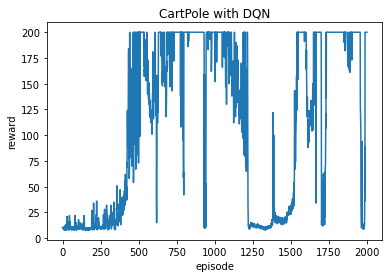

In [9]:
# outcome of each episode
plt.plot(dqn_episode_reward)
plt.title("CartPole with DQN")
plt.xlabel("episode")
plt.ylabel("reward")

Text(0, 0.5, 'reward')

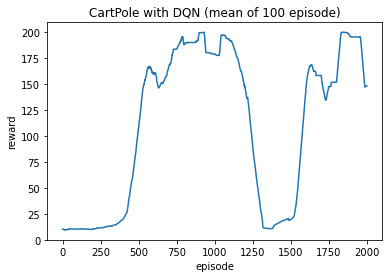

In [10]:
# outcome of episode(mean of last 100 episode)
plt.plot(average_100_step)
plt.title("CartPole with DQN (mean of 100 episode)")
plt.xlabel("episode")
plt.ylabel("reward")

Text(0, 0.5, 'loss')

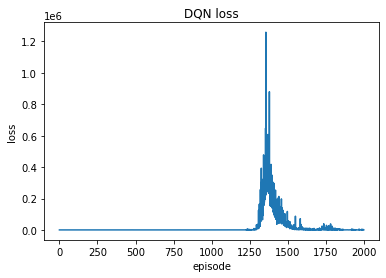

In [11]:
plt.plot(dqn_loss)
plt.title("DQN loss")
plt.xlabel("episode")
plt.ylabel("loss")

In [12]:
# save learning curve
dqn_curve = np.array(average_100_step)
np.save('curve\DQN', dqn_curve)